In [21]:
import sys
sys.path.append('../pestools')
import numpy as np
from res import Res

% matplotlib inline

##Examples of SpatialPlot class  
* makes scatter plot of PEST information with x, y locations from an observation info file

####Create res instance with ancillary observation info

In [22]:
res = Res('../cc/columbia_svda.rei.16', obs_info_file='../cc/observation_locations.csv')

####Make list of head groups to plot

In [23]:
head_groups = [g for g in res.obs_groups if 'head_' in g or 'wcr' in g]
head_groups

['head_fair', 'head_best', 'head_poor', 'head_good', 'wcrs1', 'wcrs2']

###Default plot settings  

* since we are calling SpatialPlot using a method of the Res class, the default value column to plot is "Residual"  
* by default, scatter points are sized and colored by residual magnitude ```(colorby='graduated')```. The colormap is modified so that it is always centered on zero.
* legend categories are based on the min and max residuals, and in between, quantiles representing 1, 2, and 3 standard deviations about the mean (assuming the mean is zero)
* the **plot_spatial()** method returns and instance of the **SpatialPlot** class, which includes a method (**add_shapefile()**) for overlaying information from shapefiles.
* the matplotlib figure and axis handles are accessible as attributes **fig** and **ax**

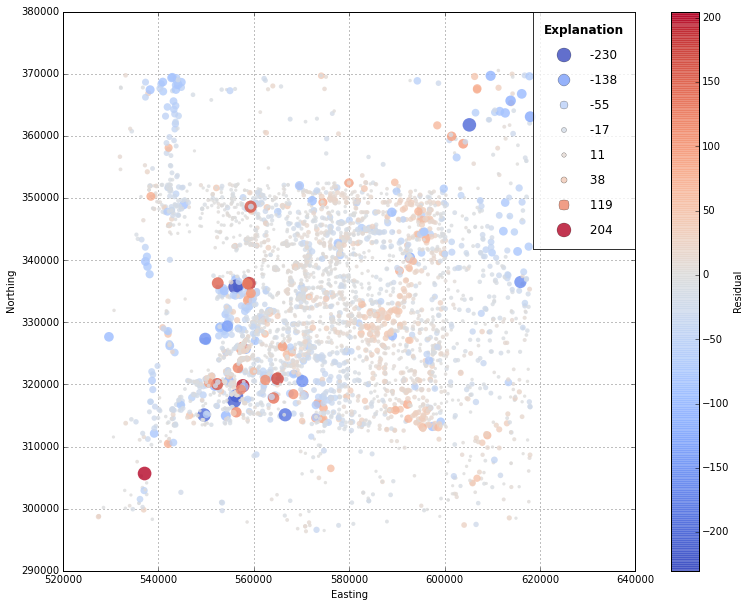

In [24]:
res.plot_spatial(head_groups)

###Binary coloring based on direction of residuals  
* ```colorby='overunder'```
* whereas the graduated coloring draws attention to outliers, this scheme draws emphasizes spatial bias

####Add a political boundary for reference from a shapefile
* shapefile must be in the same coordinate system as the PEST information, except the units may be different
    * the units of the shapefile can be scaled with the ```convert_coordinates``` argument to **add_shapefile()**; see below


reading ../cc/shps/Columbia_county.shp...
--> building dataframe... (may take a while for large shapefiles)
building PatchCollection...


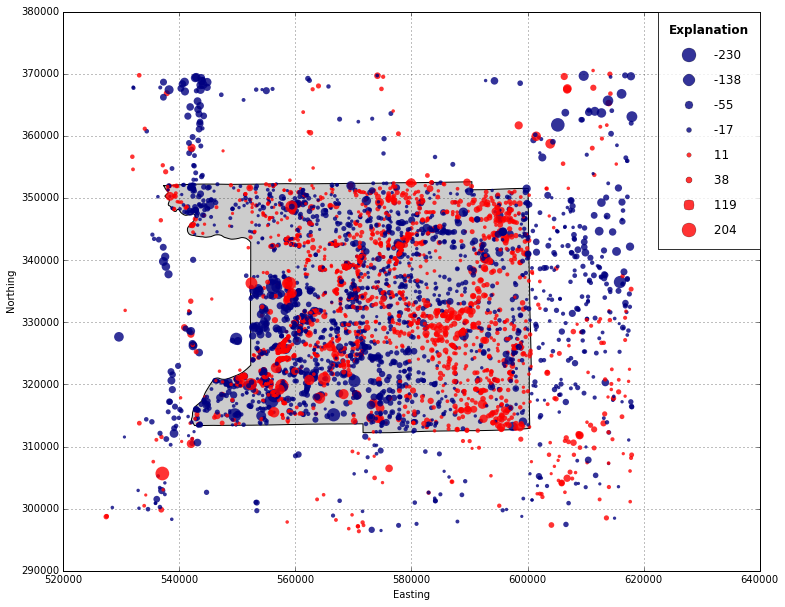

In [25]:
sp = res.plot_spatial(head_groups, colorby='binary')
shp = sp.add_shapefile('../cc/shps/Columbia_county.shp')

####Matplotlib figure and axis handles; saving figures to PDF

In [26]:
sp.fig, sp.ax

(<matplotlib.figure.Figure at 0x10ebb9b90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10de4a7d0>)

In [27]:
sp.fig.savefig('heads_binary.png')

###Coloring residual values by percent difference vs. observed values  
* baseflow residuals are much more variable than head residuals, and also may be expected to vary with the magnitude of the measured value  
* with ```colorby='pct_diff'```, the marker points are sized by the absolute magnitude of the residual (e.g., for baseflow residuals, the absolute quantity of flow missing), and colored by their percent difference from the observed value. This scheme is particularly well suite to baseflow targets in a regional groundwater model-  
    * Large targets may relatively big in size, but if they have more neutral colors towards the middle of the colormap, they are relatively well simulated.  
    * Small headwater streams may be grossly over- or under-simulated, but unless something is really wrong, the amount of flow missing is typically small. A small size for the marker point minimizes the attention drawn to these points.  
* since the colors don't correspond to the marker point sizes and are referenced in the colorbar, they are neglected in the legend.

####Customization  
* as in other PESTools methods, keywords can be supplied to **matplotlib.pyplot.scatter()**. In this case, the marker type and the colormap are customized.  
* keywords can also be supplied to the **pyplot.legend()** through the ```legend_kwds``` dictionary

In [28]:
baseflow_groups = [g for g in res.obs_groups if 'stream' in g or 'headwaters ' in g]
baseflow_groups

['cc_streams', 'sm_streams', 'lrg_streams', 'zero_streams']

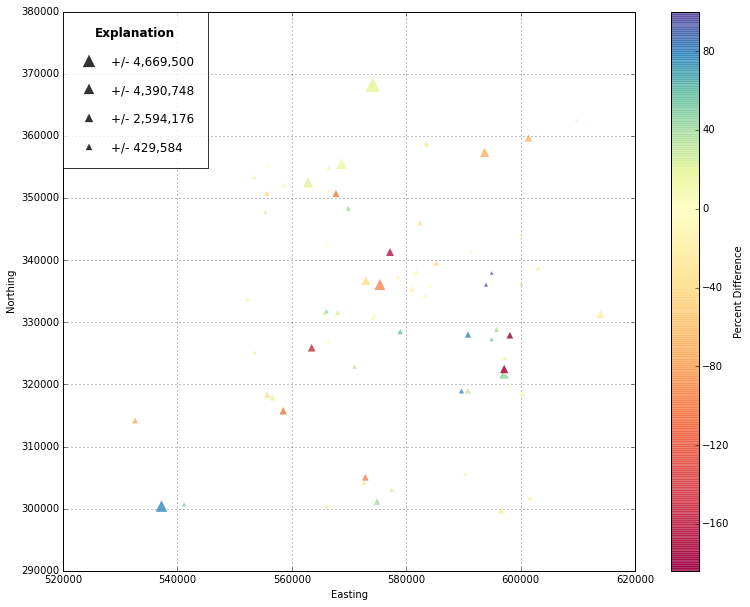

In [29]:
sp = res.plot_spatial(baseflow_groups, colorby='pct_diff', marker='^', 
                       legend_kwds={'loc':2, 'labelspacing': 1.3, 'borderpad': 1.2},
                       cmap='Spectral')

###Further customization  
It is difficult or impossible to have default settings that will suit any type of data that might be included in a PEST run. Therefore, the marker sizes and the legend values can also be customized.

####Customization of shapefile layers
The facecolor, edgecolor, transparency (alpha value), drawing order (zorder) and coordinate unit conversion for shapefile layers can be supplied to **add_shapefile**. Additional customization can be supplied as keyword arguments to  

**matplotlib.collections.LineCollection** (points)  
**matplotlib.collections.LineCollection** (linework)  
**matplotlib.patches.PathPatch** (polygons)

####The extent of the plot can also be reset to the bounding box of the shapefile
by adding ```reset_extent=True``` as an argument


reading ../cc/shps/Flowlines.shp...
--> building dataframe... (may take a while for large shapefiles)
building LineCollection...


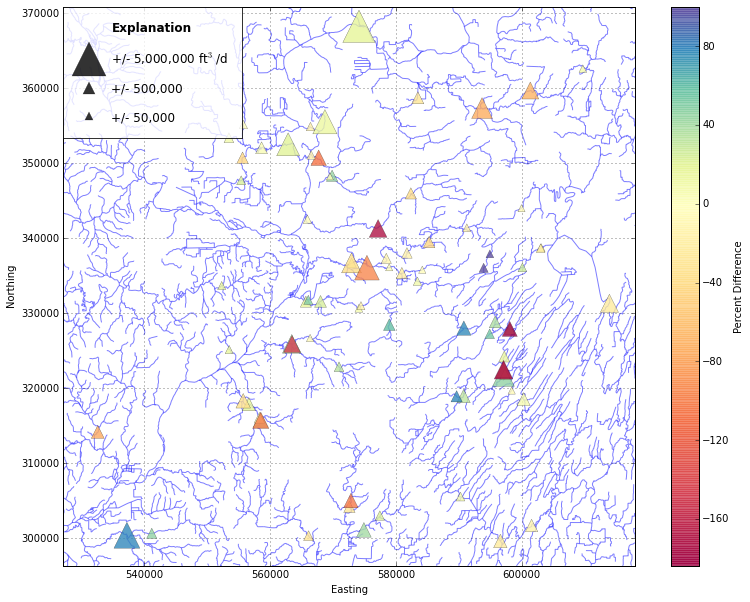

In [30]:
sp = res.plot_spatial(baseflow_groups, colorby='pct_diff', 
                       marker='^', linewidth=0.25,
                       legend_values=[5000000, 500000, 50000],
                       units='ft$^3$/d',
                       minimum_marker_size=50,
                       marker_scale=5, 
                       legend_kwds={'loc':2, 'labelspacing': 1.3, 'borderpad': 1.2},
                       cmap='Spectral')
streams = sp.add_shapefile('../cc/shps/Flowlines.shp',
                            ec='b',
                            alpha=0.5,
                            zorder=2,
                            convert_coordinates=0.3048,
                           reset_extent=True)

####Zoom to a custom extent using Matplotlib

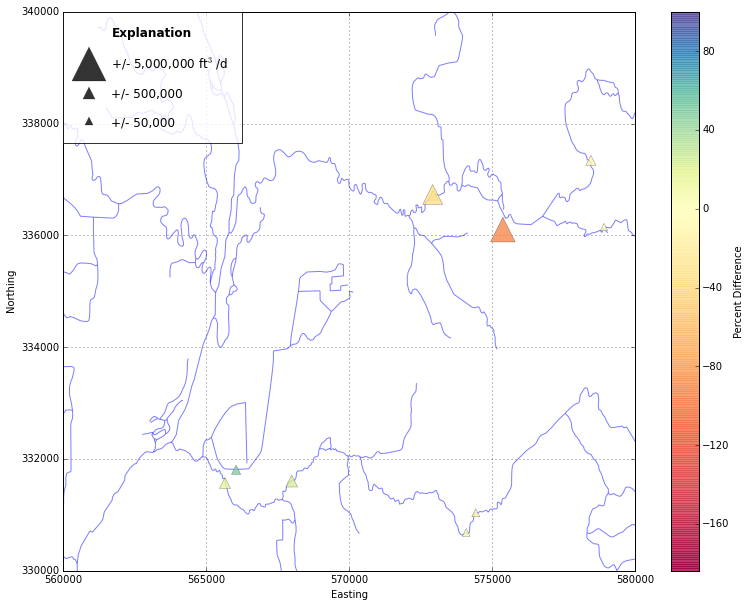

In [31]:
sp.ax.set_xlim(560000, 580000)
sp.ax.set_ylim(330000, 340000)
sp.fig

In [32]:
sp.fig.savefig('baseflow.png')

##Displaying spatial plots in slippy maps using mplleaflet  
* requires **mplleaflet** (https://github.com/jwass/mplleaflet)

In [33]:
import fiona
import mplleaflet

####First get the coordinate system using fiona

In [37]:
c = fiona.open('../cc/shps/Columbia_county.shp')
crs = c.crs
crs

{u'ellps': u'GRS80',
 u'k': 0.9996,
 u'lat_0': 0,
 u'lon_0': -90,
 u'no_defs': True,
 u'proj': u'tmerc',
 u'units': u'm',
 u'x_0': 520000,
 u'y_0': -4480000}

In [39]:
sp = res.plot_spatial(head_groups, colorby='binary', legend=False)
shp = sp.add_shapefile('../cc/shps/Columbia_county.shp')
Map = mplleaflet.display(fig=sp.fig, crs=crs, tiles='esri_aerial')
Map


reading ../cc/shps/Columbia_county.shp...
--> building dataframe... (may take a while for large shapefiles)
building PatchCollection...


###Note: could not get shapefiles of county or streams to display in slippy map, there is some kind of problem with how these are attached to the figure

###view the slippy map in a web browser

In [40]:
mplleaflet.show(fig=sp.fig, crs=crs, tiles='esri_aerial')